On considère le problème du labyrinthe.

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.pylab as pl
from matplotlib.colors import ListedColormap
np.set_printoptions(precision=3)
%matplotlib inline

On modélise le problème par:
- un ensemble d'états $\mathcal{S}=\left\{ 1,\dots,n \right\}\times
  \left\{ 1,\dots,m \right\}$ qui correspond aux cellules,
- un ensemble d'actions $\mathcal{A}=\left\{ 0,1,2,3 \right\}$ qui correspondent respectivement à "bas", "droite", "haut", "gauche", et dont on utilisera parfois la représentation sous forme de vecteur,
- un ensemble de gains $\mathcal{R}=\left\{ 0,1 \right\}$
- un ensemble d'états appelés "murs intérieurs" $\mathcal{W}\subset \mathcal{A}$.

Les transitions sont toutes déterministes, et sont telles qu'on obtient un gain de 1 lorsqu'on se déplace vers la cellule d'arrivée depuis une cellule voisine, et un gain de 0 sinon. Si l'action choisie correspond à un déplacement non-autorisé (soit qu'il mène à l'extérieur du labyrinthe, soit qu'il mène vers un mur intérieur, soit que l'état actual est un mur intérieur), l'état reste inchangé.

On travaillera avec une valeur $\gamma=.9$ fixée.

La fonction suivante servira à représenter graphiquement le labyrinthe, les politiques, ainsi que les chemins empruntés par les politiques.

In [14]:
def plot(policy=None, path=False):
    grid_size = maze.shape
    fig, ax = plt.subplots(figsize=(grid_size[1]+1, grid_size[0]+1))
    im = ax.imshow(maze, cmap='Greys', interpolation='nearest', extent=[0, grid_size[1], 0, grid_size[0]], alpha=1)
    ax.set_xticks(np.arange(0, grid_size[1]+1, 1), minor=True)
    ax.set_yticks(np.arange(0, grid_size[0]+1, 1), minor=True)
    ax.grid(which="minor", color='black', linestyle='-', linewidth=1)
    ax.set_xticks([])
    ax.set_yticks([])
    if policy is not None:
        # Plot arrows
        for i in range(grid_size[0]):
            for j in range(grid_size[1]):
                action = policy[i, j]
                ax.text(j + 0.5, grid_size[0] - i - 0.5, action_arrows[action],
                        ha='center', va='center', fontsize=12, fontweight='bold')
        if path is True:
            cmap = pl.cm.Reds
            my_cmap = cmap(np.arange(cmap.N))
            my_cmap[:,-1] = np.linspace(0, 1, cmap.N)
            my_cmap = ListedColormap(my_cmap)
            im = ax.imshow(path_array(policy), cmap=my_cmap, interpolation='nearest', extent=[0, grid_size[1], 0, grid_size[0]], alpha=.5)
    plt.show()

Le code suivant construit un labyrinthe aléatoire de taille 30 x 30, avec des murs intérieurs qui ne sont pas tirés de façon indépendante. La case de départ est (0,0) (celle en haut à gauche), et la case d'arrivée est (29,29) (celle en bas à droite). Il est fait en sorte que ces deux cases ne soient pas murées. Les paramètres peuvent bien sûr être modifiés.

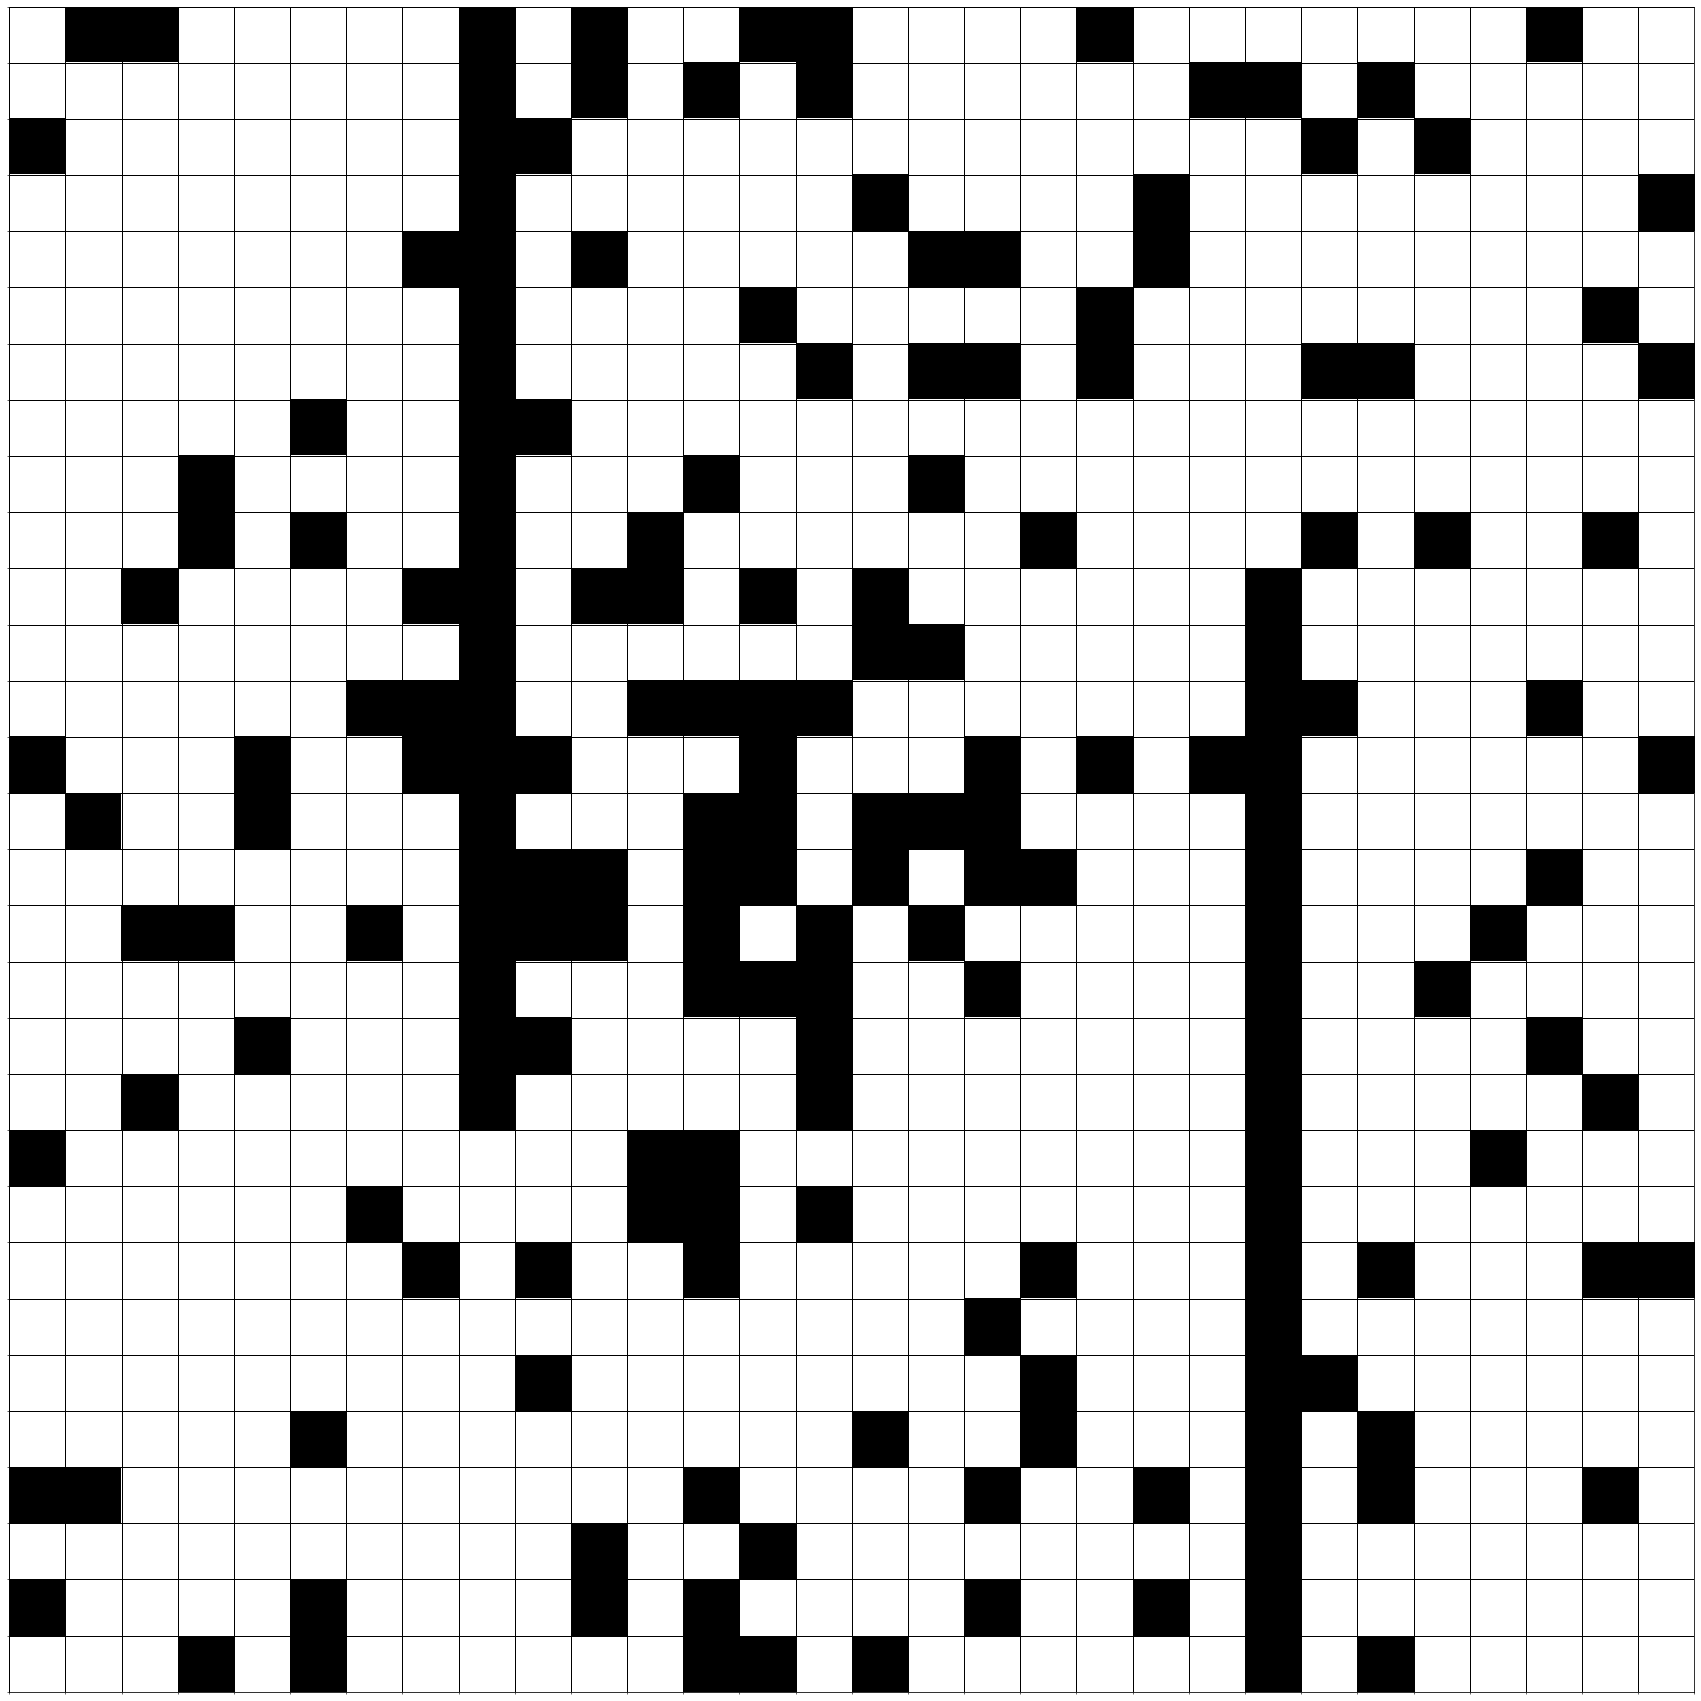

In [15]:
width = 30
height = 30
maze_size = (height, width) # nb lines & nb rows
start_cell = (0,0)
target_cell = (height-1, width-1)

maze = np.random.binomial(1, p=.15, size=maze_size)
maze[:round(2*width/3),round(height/4)] = 1
maze[round(width/3):,round(3*height/4)] = 1
chl = round(2*height/5)
chu = round(3*height/5)
cwl = round(2*width/5)
cwu = round(3*width/5)
maze[chl:chu,cwl:cwu] = np.random.binomial(1, p=.5, size=(chu-chl, cwu-cwl))
maze[start_cell] = 0
maze[target_cell] = 0
plot()

*Attention* : vérifier visuellement que le labyrinthe ainsi obtenu possède un chemin allant de la case de départ à la case d'arriver. Dans le cas contraire, relancer le code ci-dessus afin de générer un autre labyrinthe.

In [16]:
actions = [0,1,2,3]
action_coordinates = {0: np.array([1,0]),# down
                      1: np.array([0,1]), # right
                      2: np.array([-1,0]), # up
                      3: np.array([0,-1])} # left
action_arrows = ['↓', '→', '↑', '←']
gamma = .9

On ne va travailler qu'avec des politiques stationnaires déterministes $\pi:\mathcal{S}\to \mathcal{A}$. On va les représenter par des arrays de taille $n\times m$ à valeurs dans $\left\{ 0,1,2,3 \right\}$.

*Question 1*: Compléter la fonction suivante qui prend en entrée un état (un couple de la forme (i,j)) et une action (un entier parmi 0,1,2,3), et qui renvoie r, s_, qui sont respectivement le gain et le nouvel état. On pourra utiliser la fonction `tuple` qui convertit en n-uplet un objet d'un autre type.

In [17]:
def transition(s, a):
    i, j = s
    if a == 0:  # down
        if i < maze.shape[0] - 1 and maze[i + 1, j] != 1:
            s_ = (i + 1, j)
            r = 1 if s_ == target_cell else 0
        else:
            s_ = s
            r = 0
    elif a == 1:  # right
        if j < maze.shape[1] - 1 and maze[i, j + 1] != 1:
            s_ = (i, j + 1)
            r = 1 if s_ == target_cell else 0
        else:
            s_ = s
            r = 0
    elif a == 2:  # up
        if i > 0 and maze[i - 1, j] != 1:
            s_ = (i - 1, j)
            r = 1 if s_ == target_cell else 0
        else:
            s_ = s
            r = 0
    elif a == 3:  # left
        if j > 0 and maze[i, j - 1] != 1:
            s_ = (i, j - 1)
            r = 1 if s_ == target_cell else 0
        else:
            s_ = s
            r = 0
    return r, s_

*Question 2*: Compléter les fonctions suivantes qui calculent l'image d'une fonction état-valeur par les opérateurs de Bellman $B_{\pi}^{(V)}$ et $B_*^{(V)}$. Une fonction état-valeur sera représentée par un array de taille $n\times m$, et une politique (qu'on suppose donc stationnaire et déterministe), par un array de taille $n\times m$ à valeurs dans $\left\{ 0,1,2,3 \right\}$.

In [18]:
def B_pi(v, pi):
    v_ = np.zeros_like(v)
    for i in range(v.shape[0]):
        for j in range(v.shape[1]):
            s = (i, j)
            a = pi[s]
            r, s_ = transition(s, a)
            v_[s] = pi[s] * (r + gamma * v[s_])
    return v_

def B_star(v):
    v_ = np.zeros_like(v)
    for i in range(v.shape[0]):
        for j in range(v.shape[1]):
            s = (i, j)
            max_value = -np.inf
            for a in actions:
                r, s_ = transition(s, a)
                value = r + gamma * v[s_]
                if value > max_value:
                    max_value = value
            v_[s] = max_value
    return v_

*Question 3*: Compléter la fonction suivante qui renvoie une politique gloutonne par rapport à une fonction état-valeur donnée en entrée. On pourra utiliser la fonction np.argmax.

In [19]:
def greedy_policy(v):
    pi = np.zeros_like(maze)
    for i in range(v.shape[0]):
        for j in range(v.shape[1]):
            s = (i, j)
            max_value = -np.inf
            for a in actions:
                r, s_ = transition(s, a)
                value = r + gamma * v[s_]
                if value > max_value:
                    max_value = value
                    pi[s] = a
    return pi

*Question 4*: Compléter la fonction suivante qui renvoie le chemin suivi par la politique donnée en argument depuis la cellule de départ. On considère qu'un chemin se termine lorsque qu'une transition donne une cellule déjà visitée par le chemin. Le chemin sera donné sous la forme d'un array de taille $n\times m$ à valeurs dans {0,1}, où 1 correspond aux cellules visitées par le chemin.

In [20]:
def path_array(policy):
    grid_size = maze.shape
    path = np.zeros(grid_size)
    visited = set()
    current_cell = start_cell

    while current_cell not in visited:
        visited.add(current_cell)
        path[current_cell] = 1
        action = policy[current_cell]
        next_cell = tuple(np.array(current_cell) + action_coordinates[action])
        if next_cell in visited:
            break
        current_cell = next_cell

    return path


Le code suivant donne une fonction état-valeur aléatoire, qui servira de point de départ pour une itération valeur.

In [21]:
v = np.random.random(maze.shape)

*Question 5*: Calculer 20 itérations d'une itération valeur. Observer alors le chemin donné par la politique gloutonne grâce à la fonction plot appelée avec l'option path=True. Un chemin de longeur minimale a-t-il été trouvé ? Si besoin, calculer 20 itérations supplémentaires en relançant la cellule.

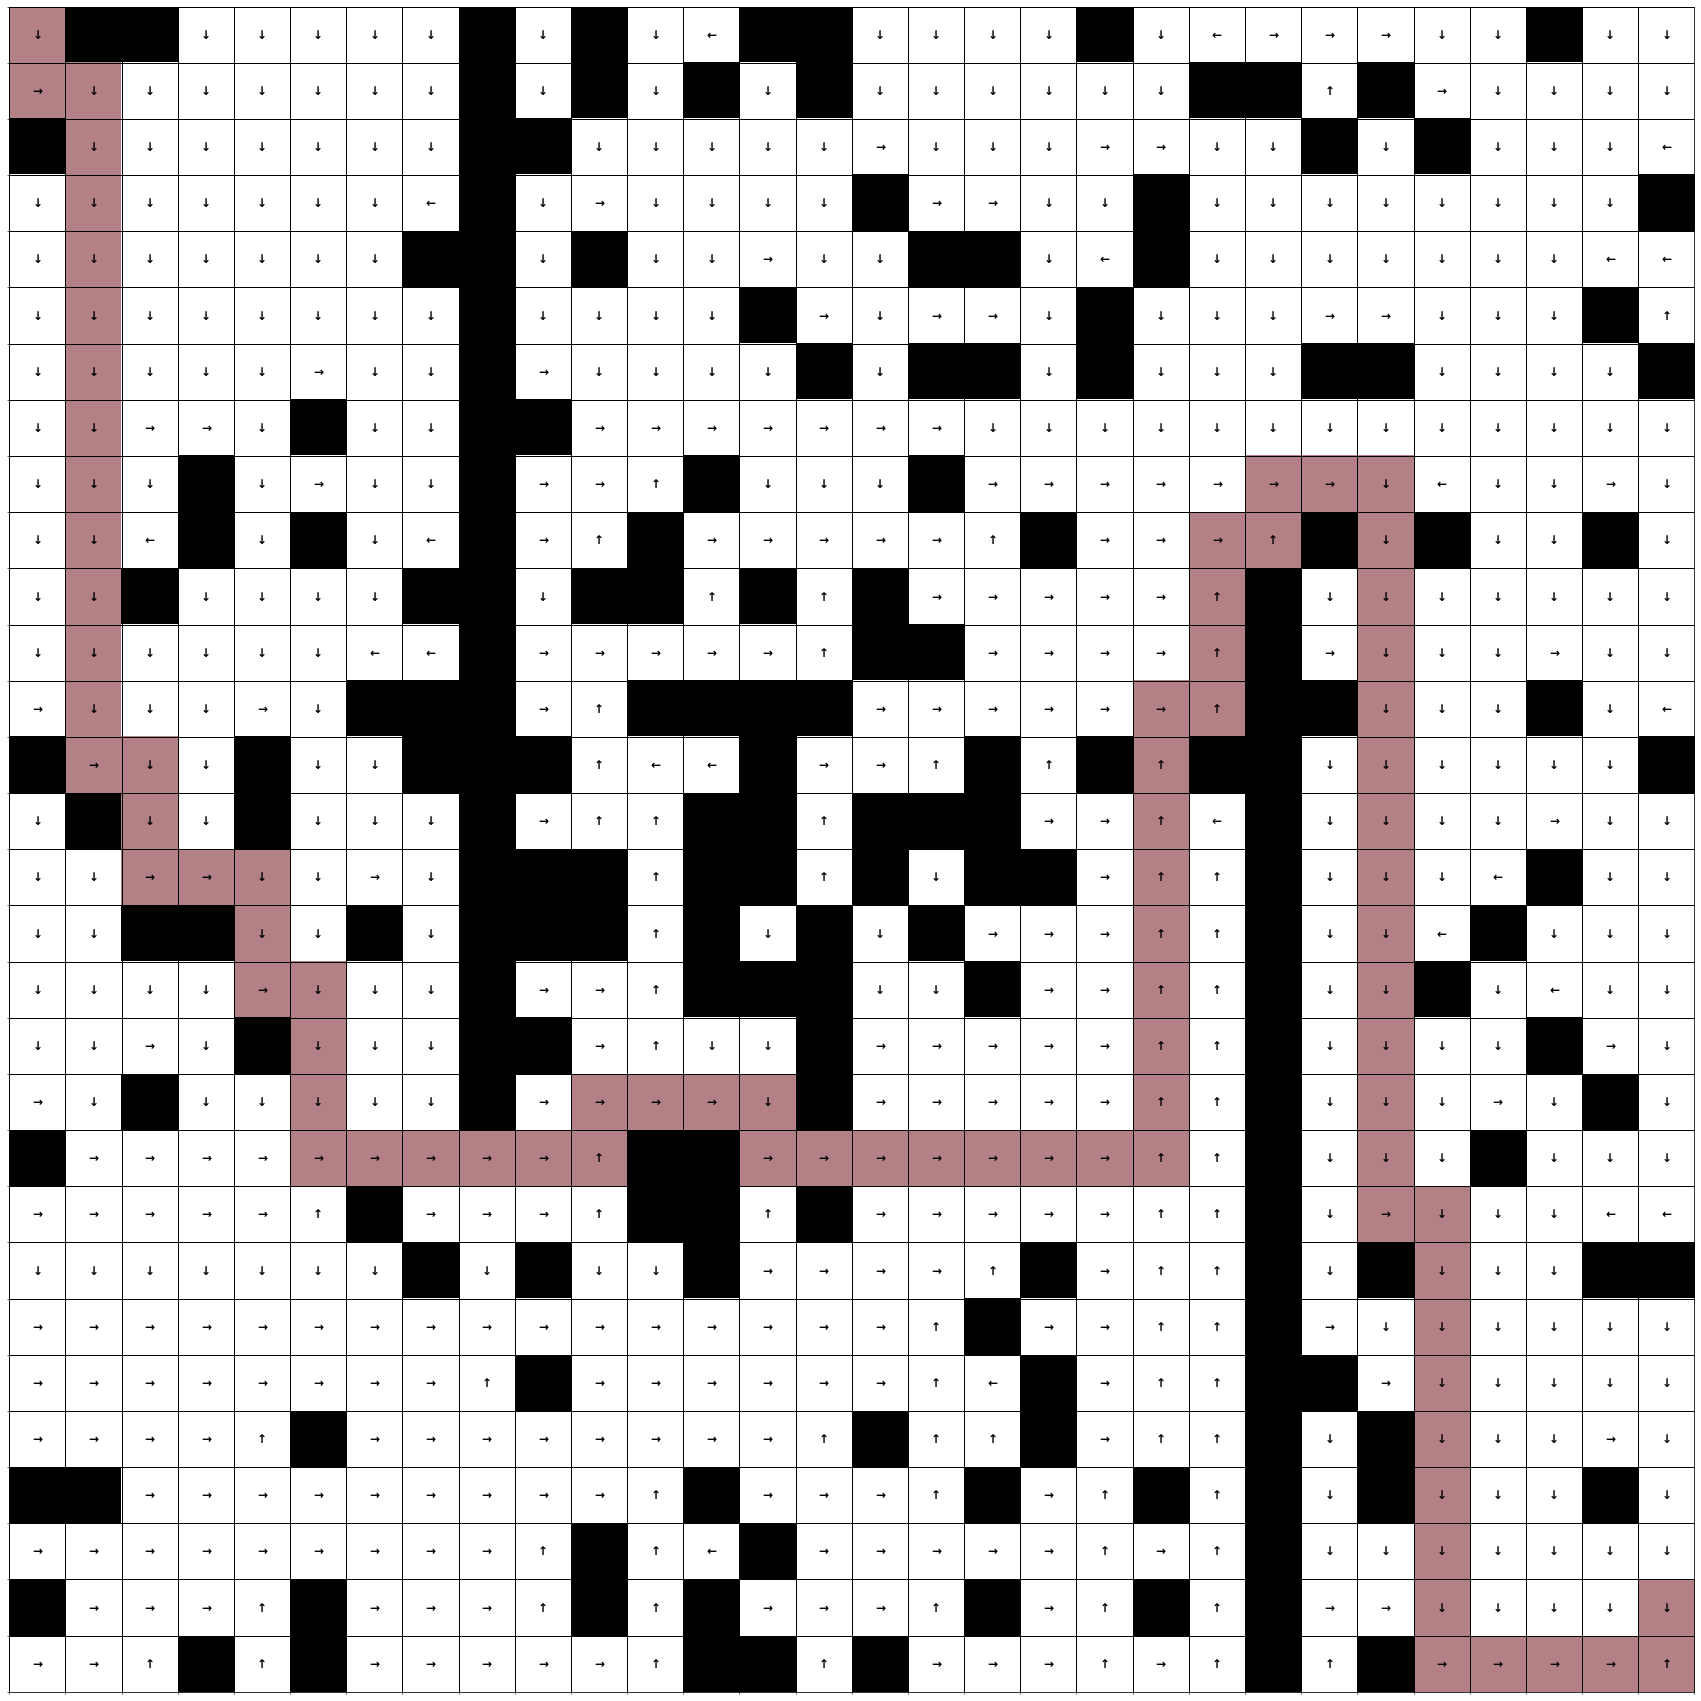

In [22]:
v = np.random.random(maze.shape)

for _ in range(100):
    v = B_star(v)

policy = greedy_policy(v)
plot(policy, path=True)



*Question 6*: Recommencer l'itération valeur, et s'arrêter lorsque la politique gloutonne reste inchangée pendant un certain nombre d'itérations (par exemple 100). A quelle itération cette politique a-t-elle été atteinte ? Combien de fois la fonction `transition` a-t-elle été appelée jusqu'à cette itération ?

*Question 7*: Implémenter une itération de politique, où pour chaque politique $\pi$ considérée, $v_{\pi}$ est approximée par 5 itérations de $B_{\pi}$. Combien de fois la fonction `transition` a-t-elle été appelée jusqu'à ce que la politique obtenue semble avoir convergé ?

Même question où au lieu de toujours calculer exactement 5 itérations de $B_{\pi}$, on en calcule autant que nécessaire pour que la fonction valeur obtenue soit supérieure à la fonction valeur précédente (et distincte). Autrement dit: $v_{k+1}=B^{m_k}_{\pi_g\left[ v_k \right] }v_k$, où $m_k$ est le plus petit entier tel que $v_{k+1}\geqslant v_k$ avec $v_{k+1}\neq v_k$.

*Question 8*: Il y a-t-il mieux à faire que de partir d'une fonction état-valeur aléatoire ?

*Question 9*: Connaissant la structure du problème, comment pourrait-on modifier l'itération valeur afin d'être plus économe en calcul à chaque itération ?